<a href="https://colab.research.google.com/github/MesutEmpire-CS-Projects/Road-Classifier-Model/blob/main/TRAFFIC_CLASSIFIER_FINAL_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,roc_curve, auc
from sklearn.preprocessing import LabelEncoder,LabelBinarizer
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score,StratifiedShuffleSplit,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle

# 1. Data Preparation

## 1.1 Import the data

In [ ]:
traffic_data = pd.read_excel('drive/MyDrive/CS 4.1/KNOWLEDGE BASED SYSTEMS/Assignments/TRAFFIC ACCIDENTS DATA.xlsx')
print(traffic_data.columns)
traffic_data.head()

Index(['Date', 'Accident Spot', 'Area', 'County', 'Road/ Highway',
       'Brief Accident Details/Cause', 'Victims',
       'Total people confirmed dead', 'Time of the Accidents',
       'Weather conditions'],
      dtype='object')


,Date,Accident Spot,Area,County,Road/ Highway,Brief Accident Details/Cause,Victims,Total people confirmed dead,Time of the Accidents,Weather conditions
0,2023-08-08,Sobea,Sobea,Nakuru,Nakuru-Eldoret Highway,Head on Collision,Passengers,4,4.30 pm,NaN
1,2023-08-07,Maai-Mahiu,Naivasha,Nakuru,Maai-Mahiu Naivasha Highway,vehicle and motorcycle collision,Passengers,1,5.50 pm,NaN
2,2023-07-25,Ntulele,Ntulele,Narok,Narok Mai Mahiu road,Head on Collision,Drivers/Occupants,4,NaN,NaN
3,2022-12-02,Suswa,Suswa,Narok,Narok Mai Mahiu road,Head on Collision,Driver and passengers,3,6.00 pm,NaN
4,2022-12-01,Mutira,Mutira,Kirinyaga,Kerugoya-Karatina Road,Run over,Pedestrian,1,NaN,NaN


## 1.2 Identify Missing Values

In [ ]:
display(traffic_data.isna().sum())

,0
Date,1
Accident Spot,0
Area,0
County,0
Road/ Highway,1
Brief Accident Details/Cause,2
Victims,18
Total people confirmed dead,9
Time of the Accidents,56
Weather conditions,80


## 1.3 Fill Missing Values

In [ ]:
# Convert 'Total people confirmed dead' to numeric values, coercing errors to NaN
traffic_data['Total people confirmed dead'] = pd.to_numeric(traffic_data['Total people confirmed dead'], errors='coerce')

# Group by 'Road/ Highway' and 'Accident Spot', then calculate the mean
mean_deaths = traffic_data.groupby(['Road/ Highway', 'Accident Spot'])['Total people confirmed dead'].transform('mean')

# Fill NaN values in 'Total people confirmed dead' with the calculated mean
traffic_data['Total people confirmed dead'].fillna(mean_deaths, inplace=True)

# If mean for a group is still NaN (no valid data for that group), fill with 0 as a fallback
traffic_data['Total people confirmed dead'].fillna(0, inplace=True)

# Verify the changes
print(traffic_data[['Road/ Highway', 'Accident Spot', 'Total people confirmed dead']].head())


                 Road/ Highway Accident Spot  Total people confirmed dead
0       Nakuru-Eldoret Highway         Sobea                          4.0
1  Maai-Mahiu Naivasha Highway    Maai-Mahiu                          1.0
2         Narok Mai Mahiu road       Ntulele                          4.0
3         Narok Mai Mahiu road         Suswa                          3.0
4       Kerugoya-Karatina Road        Mutira                          1.0


<ipython-input-4-fc5cbab6b59a>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  traffic_data['Total people confirmed dead'].fillna(mean_deaths, inplace=True)
<ipython-input-4-fc5cbab6b59a>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(val

In [ ]:
traffic_data['Weather conditions'].fillna("Unknown", inplace=True)
traffic_data['Time of the Accidents'].fillna("Unknown", inplace=True)
traffic_data['Victims'].fillna("Unknown", inplace=True)

<ipython-input-5-5e0dbdaf5160>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  traffic_data['Weather conditions'].fillna("Unknown", inplace=True)
<ipython-input-5-5e0dbdaf5160>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

In [ ]:
# Fill remaining NaNs in text fields with a placeholder
for col in ['Accident Spot', 'Area', 'County', 'Road/ Highway']:
    traffic_data[col].fillna("Unknown", inplace=True)

<ipython-input-6-903e0b6bd73e>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  traffic_data[col].fillna("Unknown", inplace=True)


## 1.4 Feature Creation

In [ ]:
traffic_data_encoded = traffic_data.copy()

In [ ]:
# Define the classify_risk function
def classify_risk(deaths):
    if deaths == 0:
        return 'Low'
    elif deaths <= 3:
        return 'Moderate'
    else:
        return 'High'

# Apply the function to classify Risk_Level
traffic_data_encoded['Risk_Level'] = traffic_data_encoded['Total people confirmed dead'].apply(classify_risk)

## 1.5 Encoding

In [ ]:
# Transforming text data into numerical form using Label Encoding
le = LabelEncoder()

text_cols = ['Accident Spot', 'Area', 'County', 'Road/ Highway', 'Weather conditions', 'Time of the Accidents','Risk_Level','Victims','Time of the Accidents']

# Apply label encoding
for col in text_cols:
    traffic_data_encoded[col] = le.fit_transform(traffic_data_encoded[col])

# Display processed features
print("Encoded Data:")
display(traffic_data_encoded.head())

Encoded Data:


,Date,Accident Spot,Area,County,Road/ Highway,Brief Accident Details/Cause,Victims,Total people confirmed dead,Time of the Accidents,Weather conditions,Risk_Level
0,2023-08-08,53,56,19,29,Head on Collision,8,4.0,10,1,0
1,2023-08-07,24,38,19,14,vehicle and motorcycle collision,8,1.0,11,1,2
2,2023-07-25,43,45,20,31,Head on Collision,3,4.0,17,1,0
3,2022-12-02,55,58,20,31,Head on Collision,1,3.0,12,1,2
4,2022-12-01,37,36,7,7,Run over,12,1.0,17,1,2


## 1.6 Drop Columns

In [ ]:
traffic_data_encoded.isna().sum()

,0
Date,1
Accident Spot,0
Area,0
County,0
Road/ Highway,0
Brief Accident Details/Cause,2
Victims,0
Total people confirmed dead,0
Time of the Accidents,0
Weather conditions,0


In [ ]:
# Split into Features and Targets
traffic_data_ftrs = traffic_data_encoded.drop(columns=['Risk_Level','Brief Accident Details/Cause','Date'])
traffic_data_tgts = traffic_data_encoded['Risk_Level']

In [ ]:
traffic_data_encoded.isna().sum()

,0
Date,1
Accident Spot,0
Area,0
County,0
Road/ Highway,0
Brief Accident Details/Cause,2
Victims,0
Total people confirmed dead,0
Time of the Accidents,0
Weather conditions,0


## 1.7 Shuffle Dataset

In [ ]:
# Shuffle the dataset
traffic_data_ftrs, traffic_data_tgts = shuffle(traffic_data_ftrs, traffic_data_tgts, random_state=42)

## 1.8 Final Check

In [ ]:
print(f"Features Shape: {traffic_data_ftrs.shape}, Target Shape: {traffic_data_tgts.shape}")
display(traffic_data_ftrs.head())

Features Shape: (81, 8), Target Shape: (81,)


,Accident Spot,Area,County,Road/ Highway,Victims,Total people confirmed dead,Time of the Accidents,Weather conditions
30,52,54,0,26,15,5.0,6,1
0,53,56,19,29,8,4.0,10,1
22,20,35,9,11,9,0.0,17,1
31,36,34,16,22,0,1.0,17,1
18,22,24,19,28,2,52.0,13,1


# 2. Model Selection

In [ ]:
(traffic_train_ftrs,traffic_test_ftrs,traffic_train_tgts,traffic_test_tgts) = train_test_split(traffic_data_ftrs,traffic_data_tgts,test_size=0.4,random_state=42)
traffic_train_ftrs.head()
print(len(traffic_train_ftrs))
print(len((traffic_test_ftrs)))

48
33


In [ ]:
models = {
    'knn': KNeighborsClassifier,
    'naive_bayes': GaussianNB,
    # 'decision_tree': DecisionTreeClassifier,
    # 'random_forest': RandomForestClassifier,
    'logistic_regression': LogisticRegression,
    'svm': SVC,
    'mlp': MLPClassifier,
}

# Prepare data structure to store results
results = {name: [] for name in models}

display(results)


{'knn': [], 'naive_bayes': [], 'logistic_regression': [], 'svm': [], 'mlp': []}

In [ ]:
# Loop through each model performing cross validation
for name, model in models.items():
    for i in range(2, 10):
        if model == KNeighborsClassifier:
            for j in range(2, 10):
                score = cross_val_score(model(n_neighbors=j), traffic_train_ftrs, traffic_train_tgts,
                                        cv=StratifiedKFold(i), scoring='accuracy')
                mean_score = score.mean().round(2)
                results[name].append((i, j, mean_score))
        else:
            score = cross_val_score(model(), traffic_train_ftrs, traffic_train_tgts,
                                    cv=StratifiedKFold(i), scoring='accuracy')
            mean_score = score.mean()
            results[name].append((i, None, mean_score))

display(results)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

{'knn': [(2, 2, 0.48),
  (2, 3, 0.42),
  (2, 4, 0.33),
  (2, 5, 0.35),
  (2, 6, 0.25),
  (2, 7, 0.21),
  (2, 8, 0.21),
  (2, 9, 0.31),
  (3, 2, 0.44),
  (3, 3, 0.42),
  (3, 4, 0.42),
  (3, 5, 0.35),
  (3, 6, 0.33),
  (3, 7, 0.35),
  (3, 8, 0.27),
  (3, 9, 0.31),
  (4, 2, 0.48),
  (4, 3, 0.42),
  (4, 4, 0.42),
  (4, 5, 0.4),
  (4, 6, 0.29),
  (4, 7, 0.33),
  (4, 8, 0.29),
  (4, 9, 0.31),
  (5, 2, 0.48),
  (5, 3, 0.42),
  (5, 4, 0.46),
  (5, 5, 0.46),
  (5, 6, 0.36),
  (5, 7, 0.38),
  (5, 8, 0.34),
  (5, 9, 0.32),
  (6, 2, 0.5),
  (6, 3, 0.44),
  (6, 4, 0.44),
  (6, 5, 0.44),
  (6, 6, 0.4),
  (6, 7, 0.4),
  (6, 8, 0.35),
  (6, 9, 0.29),
  (7, 2, 0.48),
  (7, 3, 0.44),
  (7, 4, 0.47),
  (7, 5, 0.42),
  (7, 6, 0.34),
  (7, 7, 0.36),
  (7, 8, 0.32),
  (7, 9, 0.31),
  (8, 2, 0.52),
  (8, 3, 0.46),
  (8, 4, 0.48),
  (8, 5, 0.48),
  (8, 6, 0.42),
  (8, 7, 0.42),
  (8, 8, 0.33),
  (8, 9, 0.27),
  (9, 2, 0.5),
  (9, 3, 0.46),
  (9, 4, 0.49),
  (9, 5, 0.47),
  (9, 6, 0.44),
  (9, 7, 0.46),
  (9, 

In [ ]:
# Create the results dictionary into a DataFrame
data = [(model_name, cv_folds, n_neighbors, accuracy_score) for model_name, values in results.items() for cv_folds, n_neighbors, accuracy_score in values]
df = pd.DataFrame(data, columns=['Model', 'CV', 'Neighbors', 'Mean Score'])
df.set_index('Model', inplace=True)
display(df)

,CV,Neighbors,Mean Score
Model,,,
knn,2,2.0,0.480000
knn,2,3.0,0.420000
knn,2,4.0,0.330000
knn,2,5.0,0.350000
knn,2,6.0,0.250000
...,...,...,...
mlp,5,NaN,0.624444
mlp,6,NaN,0.625000
mlp,7,NaN,0.557823


In [ ]:
# Group the based on Model name
grouped_df = df.groupby('Model')

,CV,Neighbors,Mean Score
Model,,,
knn,2,2.0,0.48
knn,2,3.0,0.42
knn,2,4.0,0.33
knn,2,5.0,0.35
knn,2,6.0,0.25
...,...,...,...
knn,9,5.0,0.47
knn,9,6.0,0.44
knn,9,7.0,0.46


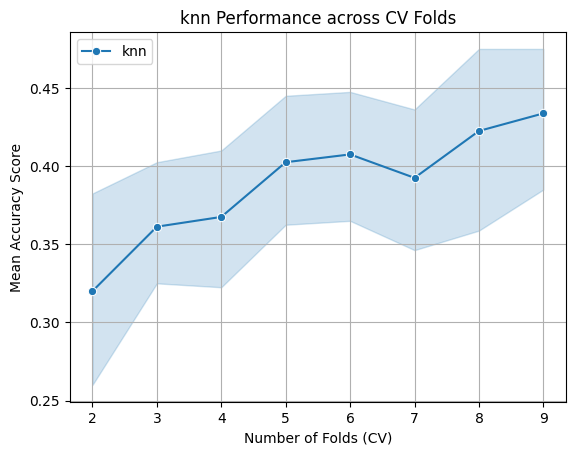

,CV,Neighbors,Mean Score
Model,,,
logistic_regression,2,NaN,0.458333
logistic_regression,3,NaN,0.708333
logistic_regression,4,NaN,0.666667
logistic_regression,5,NaN,0.791111
logistic_regression,6,NaN,0.833333
logistic_regression,7,NaN,0.724490
logistic_regression,8,NaN,0.812500
logistic_regression,9,NaN,0.785185


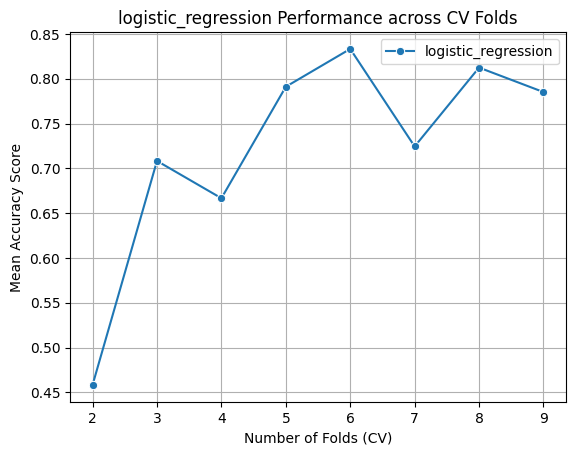

,CV,Neighbors,Mean Score
Model,,,
mlp,2,NaN,0.437500
mlp,3,NaN,0.583333
mlp,4,NaN,0.458333
mlp,5,NaN,0.624444
mlp,6,NaN,0.625000
mlp,7,NaN,0.557823
mlp,8,NaN,0.604167
mlp,9,NaN,0.622222


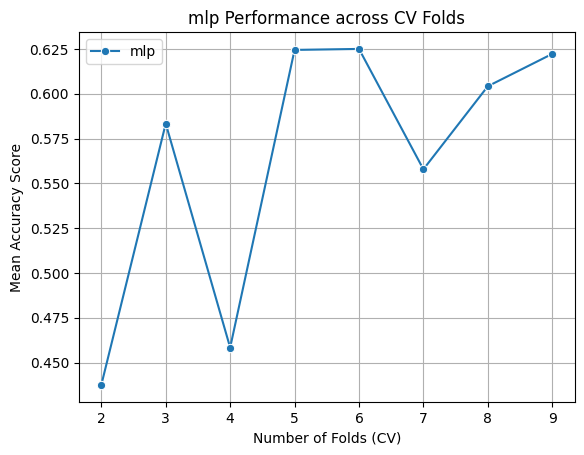

,CV,Neighbors,Mean Score
Model,,,
naive_bayes,2,NaN,0.750000
naive_bayes,3,NaN,0.812500
naive_bayes,4,NaN,0.791667
naive_bayes,5,NaN,0.811111
naive_bayes,6,NaN,0.833333
naive_bayes,7,NaN,0.785714
naive_bayes,8,NaN,0.812500
naive_bayes,9,NaN,0.792593


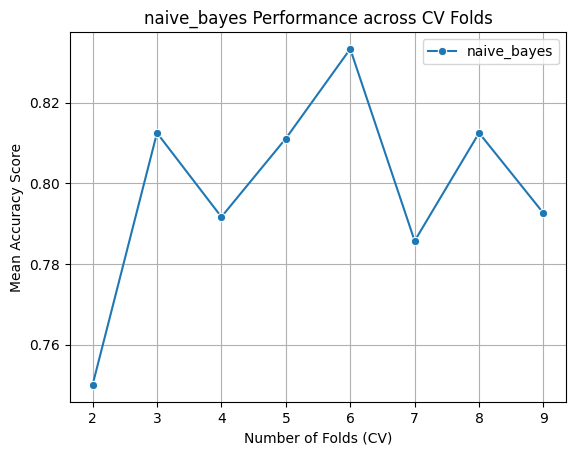

,CV,Neighbors,Mean Score
Model,,,
svm,2,NaN,0.250000
svm,3,NaN,0.291667
svm,4,NaN,0.270833
svm,5,NaN,0.293333
svm,6,NaN,0.375000
svm,7,NaN,0.231293
svm,8,NaN,0.270833
svm,9,NaN,0.314815


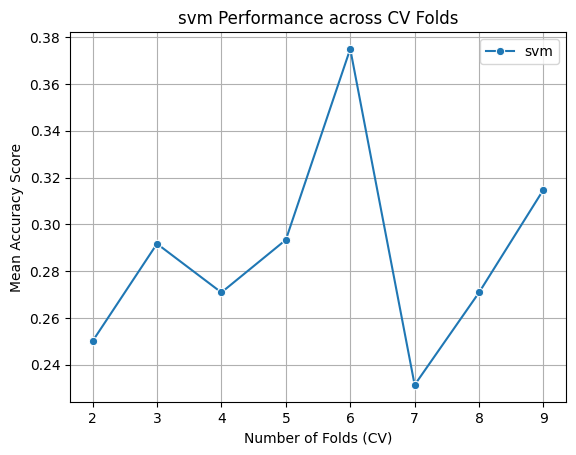

In [ ]:
for model_name, group in grouped_df:
    display(group)
    sns.lineplot(data=group, x='CV', y='Mean Score', hue='Model', marker='o')

    plt.title(f'{model_name} Performance across CV Folds')
    plt.xlabel('Number of Folds (CV)')
    plt.ylabel('Mean Accuracy Score')
    plt.grid(True)
    plt.legend()
    plt.show()

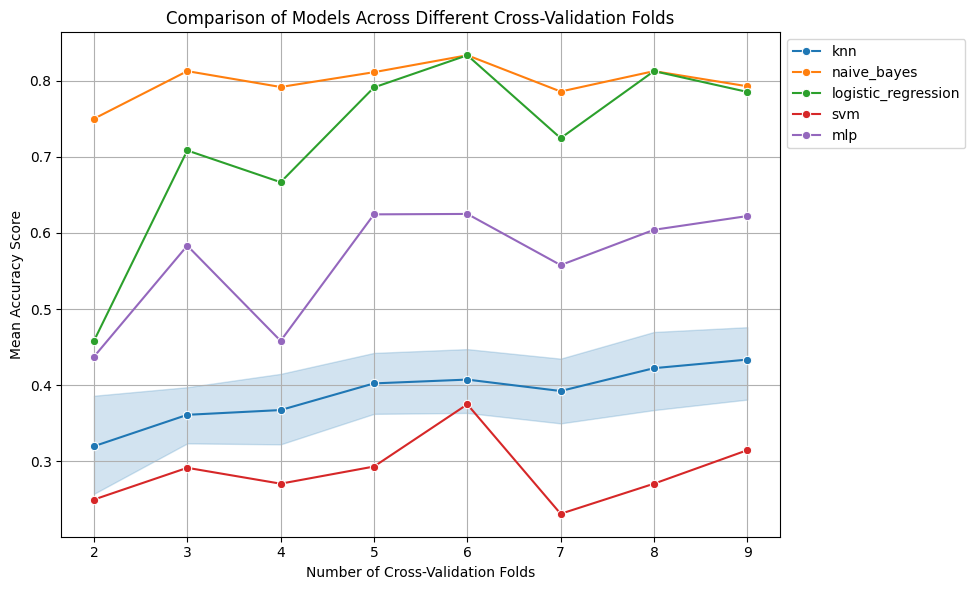

In [ ]:
# Plot the comparison across different CV folds for each model
plt.figure(figsize=(8, 6))

plt.title('Comparison of Models Across Different Cross-Validation Folds')
sns.lineplot(data=df, x='CV', y='Mean Score',hue='Model', marker='o')

plt.xlabel('Number of Cross-Validation Folds')
plt.ylabel('Mean Accuracy Score')
plt.legend(title='Model')
plt.tight_layout()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

In [ ]:
max_row = df[df['Mean Score'] == df['Mean Score'].max()]
print(max_row)
print(max_row['Neighbors'])

                     CV  Neighbors  Mean Score
Model                                         
naive_bayes           6        NaN    0.833333
logistic_regression   6        NaN    0.833333
Model
naive_bayes           NaN
logistic_regression   NaN
Name: Neighbors, dtype: float64


In [ ]:
max_row.index[0]

'naive_bayes'

In [ ]:
best_dt_model = models[max_row.index[0]]()
fit = best_dt_model.fit(traffic_train_ftrs, traffic_train_tgts)
test_predictions = fit.predict(traffic_test_ftrs)
train_accuracy = accuracy_score(traffic_train_tgts,fit.predict(traffic_train_ftrs))
test_accuracy = accuracy_score(traffic_test_tgts,test_predictions)
print(f'Train Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

Train Accuracy: 0.8333333333333334
Test Accuracy: 0.8484848484848485


# 3. Classifier Evalution

## 3.1 Confusion Matrix

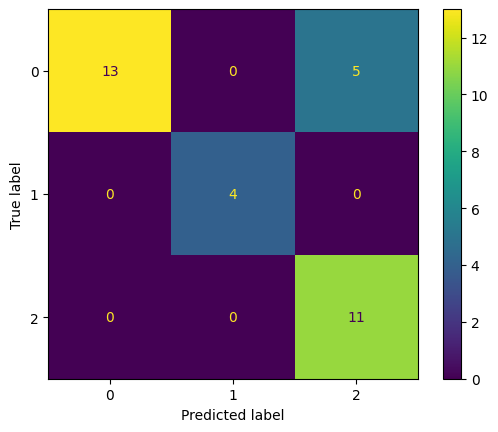

In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cm = confusion_matrix(traffic_test_tgts, test_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()

## 3.2 Classification Report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(traffic_test_tgts, test_predictions))


              precision    recall  f1-score   support

           0       1.00      0.72      0.84        18
           1       1.00      1.00      1.00         4
           2       0.69      1.00      0.81        11

    accuracy                           0.85        33
   macro avg       0.90      0.91      0.88        33
weighted avg       0.90      0.85      0.85        33



## 3.3 ROC AND AUC

In [ ]:
# n_classes = traffic_test_tgts_bin.shape[1]
# print(n_classes)

3


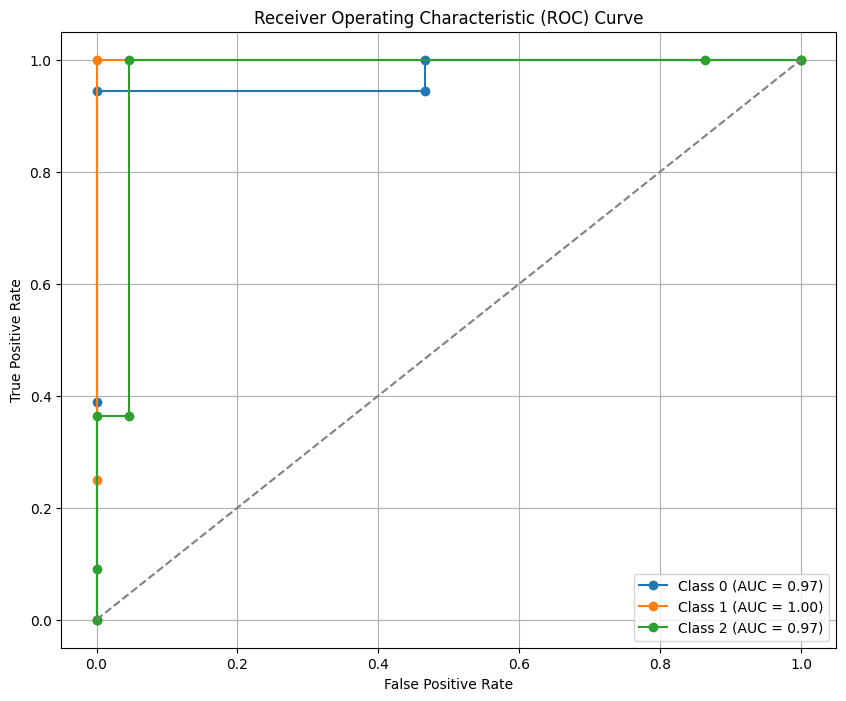

In [ ]:
# Binarize the output (traffic_test_tgts) for multi-class ROC curve
lb = LabelBinarizer()
traffic_test_tgts_bin = lb.fit_transform(traffic_test_tgts)

n_classes = traffic_test_tgts_bin.shape[1]
print(n_classes)

# Get predicted probabilities
probabilities = best_dt_model.predict_proba(traffic_test_ftrs)

plt.figure(figsize=(10, 8))

# Plot ROC curve for each class
for i in range(n_classes):
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(traffic_test_tgts_bin[:, i], probabilities[:, i])
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve for this class
    plt.plot(fpr, tpr, 'o-',label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot the "chance" line (45-degree line)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Set plot labels and title
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
import joblib
joblib.dump(best_dt_model, 'final_decision_tree_model.pkl')


['final_decision_tree_model.pkl']